In [1]:
##importing libraries
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

A user has requested how many seven day prescriptions there are for Aspirin as a proprotion of all prescriptions for Aspirin. The aim is to use as a surrogate for dosette boxes. The Pharmaceutical Journal has a good article here from earlier in the year that questions are we dispensing too many dosette boxes. It relies on small audits in one or two CCGs to extrapolate to the whole country. Dosette boxes are generally not recommended and as all good pharmacy staff will tell you they are a pain in the backside to dispense and assure yourself of the contents.

We will use medicines for long term conditions as a surrogate for indicating dosette boxes as it is once daily so prescriptions with a seven day course length are indicative of weekly scripts which are sometimes used (erroneously) to support dispensing in dosette boxes.

In [2]:
sql='''SELECT
bnf.chemical,
  SUM(CASE
      WHEN quantity_per_item=7 THEN total_quantity
      ELSE 0
  END) AS seven_day_QI,
  SUM(total_quantity) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item=7 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_7_day_QI
FROM
  ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN
  hscic.bnf as bnf
ON
  presc.bnf_code=bnf.presentation_code

WHERE
(presentation LIKE '%_Tab%' or presentation LIKE '%_Cap%')
    AND SUBSTR(bnf_code,0,2) IN ('01','02','04','06') ## here we use common BNF chapters. Chapter 3 resp is excluded due to amount of inhalers
GROUP BY
bnf.chemical
ORDER BY
  percent_7_day_QI DESC
    LIMIT 50'''


df_ltc_meds = bq.cached_read(sql, csv_path='proportion_sevendays.csv')
df_ltc_meds.head(5)

,chemical,seven_day_QI,all_QI,percent_7_day_QI
0,Biperiden Hydrochloride,154,427,0.360656
1,Ambrisentan,119,733,0.162347
2,Donepezil Hydrochloride,15929403,102690416,0.155121
3,Galantamine,1208543,9561130,0.126402
4,Memantine Hydrochloride,6532484,63451228,0.102953


These top five are very interesting. The top two are low nubers and speiclaist meds. It may be reflected that 7 days are cover for the patient to go to the hospital to get the full supply which fits with low numbers. The following three are medicines used for dementia. MCAs are not good for dementia so this requires investigation. However these medicines are not good for a measure in the general populations. Let us try another approach of identifying medicines used for long term conditions based on quantity

In [3]:
sql='''
SELECT
extract(year from month) AS year,
bnf.chemical,
SUM(items) AS total_items,
SUM(total_quantity) AS total_tabs_caps
FROM
  ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN
  hscic.bnf as bnf
ON
  presc.bnf_code=bnf.presentation_code
WHERE
(presentation LIKE '%_Tab%' or presentation LIKE '%_Cap%')
    AND SUBSTR(bnf_code,0,2) IN ('01','02','04','06') ## here we use common BNF chapters. Chapter 3 resp is excluded due to amount of inhalers
GROUP BY
bnf.chemical,
year
ORDER BY
total_items
'''


df_ltc_meds2 = bq.cached_read(sql, csv_path='seven_days.csv')
df_ltc_meds2.head()

,year,chemical,total_items,total_tabs_caps
0,2019,Rosiglitazone,1,28
1,2017,Metformin Hydrochloride/Rosiglitazone,1,14
2,2018,Zaleplon,1,28
3,2019,Potassium Iodate,1,4
4,2017,Sibutramine,1,56


In [4]:
df_2019 = df_ltc_meds2.loc[(df_ltc_meds2["year"] == 2019)].sort_values("total_tabs_caps", ascending=False)
df_2019.head(10)

,year,chemical,total_items,total_tabs_caps
1530,2019,Paracetamol,8194696,1036481444
1541,2019,Metformin Hydrochloride,10934477,966147675
1526,2019,Co-Codamol (Codeine Phos/Paracetamol),7476095,856491571
1565,2019,Atorvastatin,22112672,715175225
1559,2019,Omeprazole,15512399,593810757
1560,2019,Levothyroxine Sodium,16130649,590090510
1556,2019,Amlodipine,14944035,513479735
1554,2019,Ramipril,14395803,501628943
1549,2019,Lansoprazole,12981173,425032725
1547,2019,Bisoprolol Fumarate,12138549,378147645


From this list we will select Atorvastatin, Omeprazole, Levothryroxine, Amlodipine and Raipril as 5 common medicines used in LTC in a once daily manner. Paracetamol, co-codamol are excluded as can be used when required and for short term illnesses. 

In [12]:
sql = '''
SELECT
  month,
  pct,
  SUM(CASE
      WHEN quantity_per_item=7 THEN total_quantity
      ELSE 0
  END) AS seven_day,
  SUM(total_quantity) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item=7 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_7_day
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atrovastatin
bnf_code LIKE "0103050P0%" OR ##omeprazole
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%')
GROUP BY
  month,pct
ORDER BY
  percent_7_day DESC
    '''

df_mca = bq.cached_read(sql, csv_path='mca_askets.csv')
df_mca.head()

GenericGBQException: Reason: 400 SELECT list expression references column month which is neither grouped nor aggregated at [3:3]

In [ ]:
df_mca.plot.bar(x='pct', y='percent_7_day', figsize=(20,10))

In [13]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_mca, title=" Proportion of common LTC med \n as seven day quantities", column='percent_7_day_QI', separate_london=True)
plt.show()

BaseException: Data contains CCG codes we don't know about: ['107' '110' '111' '112' '116' '13R' '13V' '13X' '14A' '14E' '14F' '14G'
 '14H' '14K' '209' '211' '212' '215' '218' '310' '313' '413' '414' '615'
 '704' '720' '909' 'AA8' 'AAX' 'AC2' 'ACD' 'ACH' 'AD9' 'ADH' 'ADN' 'AE8'
 'AH7' 'AJ3' 'AJ6' 'AJT' 'AKQ' 'AKV' 'AQM' 'ARD' 'ARF' 'ARG' 'AT0' 'ATK'
 'AVQ' 'AWH' 'AXG' 'AXM' 'DAA' 'DAN' 'DEC' 'DJT' 'DL0' 'DLD' 'DMH' 'DNK'
 'DR3' 'NBF' 'NCN' 'NDA' 'NDJ' 'NDL' 'NEQ' 'NFH' 'NHT' 'NI3' 'NKB' 'NKI'
 'NL1' 'NL8' 'NLF' 'NLG' 'NLO' 'NLX' 'NMG' 'NMS' 'NNC' 'NNF' 'NNS' 'NO0'
 'NPR' 'NQ7' 'NQA' 'NQH' 'NQL' 'NQV' 'NR3' 'NR5' 'NT4' 'NTP' 'NTV' 'NV1'
 'NV6' 'NVC' 'NVE' 'NW0' 'NWE' 'NWX' 'NX1' 'NYG' 'R1A' 'R1D' 'R1F' 'R1J'
 'R1K' 'R1L' 'RA9' 'RAJ' 'RBZ' 'RCB' 'RCD' 'RCE' 'RCF' 'RDR' 'RE9' 'RFR'
 'RFS' 'RGP' 'RGQ' 'RGR' 'RH5' 'RH8' 'RHA' 'RJ1' 'RJ2' 'RJ7' 'RJ8' 'RJC'
 'RL4' 'RLQ' 'RLY' 'RM1' 'RMC' 'RN3' 'RNA' 'RNN' 'RNU' 'RPG' 'RQ3' 'RQX'
 'RRE' 'RRF' 'RRU' 'RRV' 'RT2' 'RTD' 'RTF' 'RTG' 'RTK' 'RTQ' 'RTR' 'RTV'
 'RTX' 'RV3' 'RV9' 'RVR' 'RVW' 'RW5' 'RWE' 'RWK' 'RWX' 'RX6' 'RXA' 'RXC'
 'RXE' 'RXG' 'RXH' 'RXK' 'RXM' 'RXQ' 'RXX' 'RY1' 'RY2' 'RY3' 'RY4' 'RY5'
 'RY6' 'RY7' 'RY8' 'RYF' 'RYG' 'RYK' 'RYW' 'RYX' 'RYY']

<Figure size 864x504 with 0 Axes>

KeyError: 'month'

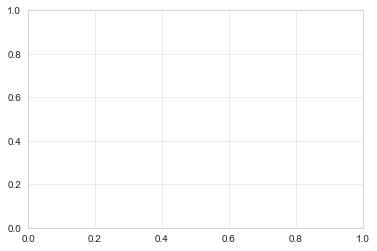

In [14]:
#create sample deciles

charts.deciles_chart(
        df_mca,
        period_column='month',
        column='percent_7_day_QI',
        title="Proportion of common LTC med \n as seven day quantities",
        show_outer_percentiles=True)

#add in example CCG (Islington - 08H)
df_subject = mca.loc[mca['PCO_CODE'] == '08H']
plt.plot(df_subject['month'], df_subject['percent_7_day_QI'], 'r--')

plt.show()